# Delta Method Quality of Approximation

This notebook explores when the delta method gives a poor approximation even when $\hat{\theta}$ is nearly Gaussian.

We investigate:
- Distribution of $\sqrt{n}(\hat{\theta} - \theta)$ vs. $N(0, \sigma^2)$
- Distribution of $\sqrt{n}(\phi(\hat{\theta}) - \phi(\theta))$ vs. $N(0, \phi'(\theta)^2\sigma^2)$
- Cases where $\hat{\theta}$ is very nearly Gaussian but $\phi(\hat{\theta})$ is not

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)

## 1. Define the Distribution and Parameters

In [2]:
# True parameter
theta = 0.0

# Sample size
n = 100  # Can adjust this to see how asymptotics kick in

# Number of simulations
n_simulations = 10000

# Define the distribution of X_i
# Example: Normal distribution with mean theta and variance sigma^2
sigma_squared = 1.0

def sample_Xi(theta, n, sigma_squared=1.0):
    """
    Sample n i.i.d. observations from the distribution.
    
    Parameters:
    -----------
    theta : float
        True parameter (mean)
    n : int
        Sample size
    sigma_squared : float
        Variance parameter
    
    Returns:
    --------
    array : n samples from the distribution
    """
    # Example: Normal distribution
    return np.random.normal(theta, np.sqrt(sigma_squared), n)
    
    # Alternative examples to try:
    # Exponential (shifted): return np.random.exponential(1.0, n) + (theta - 1.0)
    # Uniform: return np.random.uniform(theta - np.sqrt(3*sigma_squared), theta + np.sqrt(3*sigma_squared), n)
    # Poisson (for positive theta): return np.random.poisson(theta, n)

## 2. Define the Function φ


In [3]:
def phi(x):
    """
    The transformation function φ.
    
    Current: tanh with steep slope - nearly flat then suddenly steep
    
    Try different examples:
    - Linear: return x  (sanity check - should work perfectly)
    - Quadratic: return x**2
    - Exponential: return np.exp(x)
    - Log: return np.log(x)  (for x > 0)
    - Inverse: return 1/x  (for x > 0)
    - Piecewise smooth: return x**3 if x > 0 else -(-x)**3
    """
    # Nearly flat then steep: tanh function with steep slope
    return np.tanh(10*(x - theta))

def phi_derivative(x):
    """
    The derivative φ'(x).
    
    Make sure this matches your phi function
    For tanh(10(x - theta)): φ'(x) = 10 * sech²(10(x - theta)) = 10(1 - tanh²(10(x - theta)))
    """
    # Derivative of tanh(10(x - theta))
    return 10 * (1 - np.tanh(10*(x - theta))**2)

# Compute φ(θ) and φ'(θ)
phi_theta = phi(theta)
phi_prime_theta = phi_derivative(theta)

print(f"φ(θ) = φ({theta}) = {phi_theta:.6f}")
print(f"φ'(θ) = φ'({theta}) = {phi_prime_theta:.6f}")

φ(θ) = φ(0.0) = 0.000000
φ'(θ) = φ'(0.0) = 10.000000


## 3. Visualize the Function φ

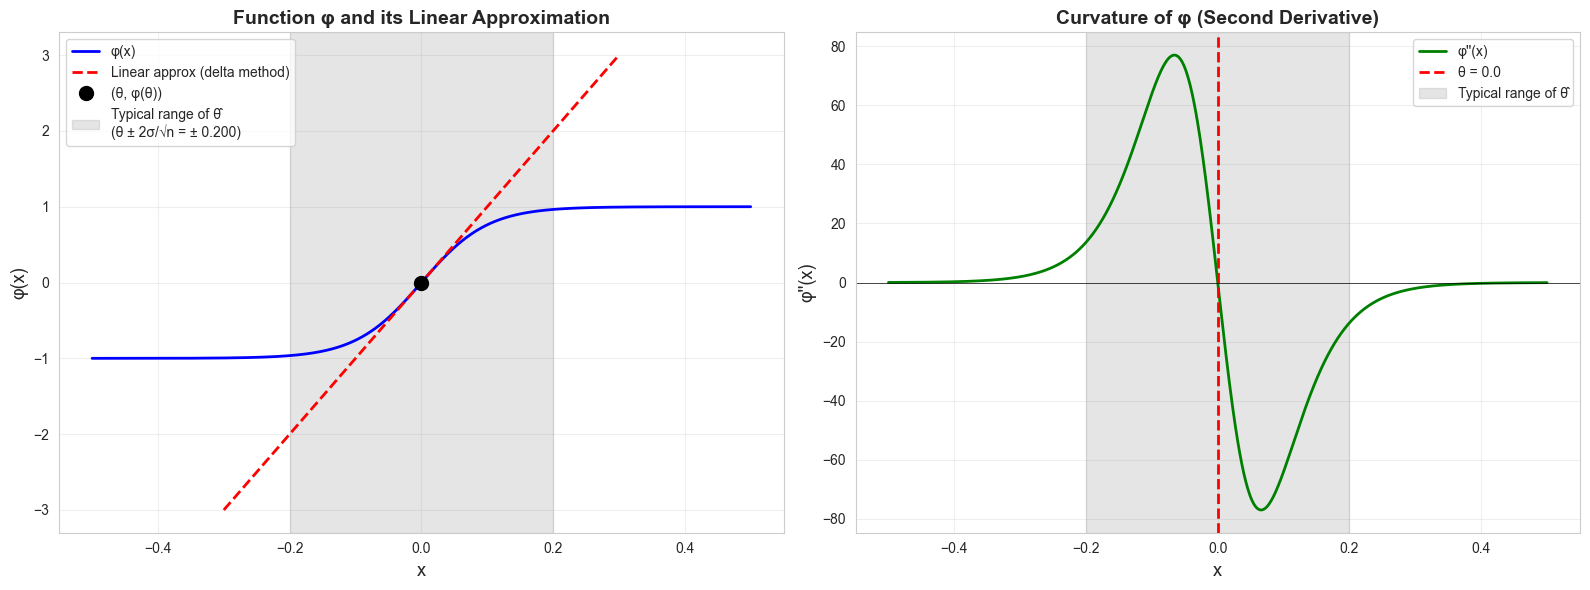


φ'(θ) = 10.0000
φ''(θ) ≈ 0.0000


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot the function φ
ax = axes[0]
# Plot over a wider range to see the full behavior
x_vals_wide = np.linspace(theta - 0.5, theta + 0.5, 1000)
y_vals_wide = np.array([phi(x) for x in x_vals_wide])

ax.plot(x_vals_wide, y_vals_wide, 'b-', linewidth=2, label='φ(x)')

# Linear approximation (delta method) - only near theta
x_vals_near = np.linspace(theta - 3*np.sqrt(sigma_squared/n), 
                          theta + 3*np.sqrt(sigma_squared/n), 1000)
linear_approx = phi_theta + phi_prime_theta * (x_vals_near - theta)
ax.plot(x_vals_near, linear_approx, 'r--', linewidth=2, label='Linear approx (delta method)')

# Mark the point (θ, φ(θ))
ax.plot(theta, phi_theta, 'ko', markersize=10, label=f'(θ, φ(θ))', zorder=5)

# Shade the region where θ̂ typically falls
ci_lower = theta - 2*np.sqrt(sigma_squared/n)
ci_upper = theta + 2*np.sqrt(sigma_squared/n)
ax.axvspan(ci_lower, ci_upper, alpha=0.2, color='gray', 
           label=f'Typical range of θ̂\n(θ ± 2σ/√n = ± {2*np.sqrt(sigma_squared/n):.3f})')

ax.set_xlabel('x', fontsize=13)
ax.set_ylabel('φ(x)', fontsize=13)
ax.set_title('Function φ and its Linear Approximation', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot the second derivative to show curvature
ax = axes[1]

# Numerical second derivative
h = 1e-6
second_deriv = [(phi(x+h) - 2*phi(x) + phi(x-h))/h**2 for x in x_vals_wide]

ax.plot(x_vals_wide, second_deriv, 'g-', linewidth=2, label="φ''(x)")
ax.axvline(theta, color='red', linestyle='--', linewidth=2, label=f'θ = {theta}')
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

# Shade the region where θ̂ typically falls
ax.axvspan(ci_lower, ci_upper, alpha=0.2, color='gray',
           label=f'Typical range of θ̂')

ax.set_xlabel('x', fontsize=13)
ax.set_ylabel("φ''(x)", fontsize=13)
ax.set_title('Curvature of φ (Second Derivative)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compute second derivative at theta
phi_double_prime_theta = (phi(theta+h) - 2*phi(theta) + phi(theta-h))/h**2

print(f"\nφ'(θ) = {phi_prime_theta:.4f}")
print(f"φ''(θ) ≈ {phi_double_prime_theta:.4f}")

## 4. Run Simulations

In [5]:
# Store results
theta_hats = np.zeros(n_simulations)
phi_theta_hats = np.zeros(n_simulations)

# Run simulations
for i in range(n_simulations):
    # Sample data
    X = sample_Xi(theta, n, sigma_squared)
    
    # Compute empirical mean (estimator)
    theta_hat = np.mean(X)
    
    # Apply transformation
    phi_theta_hat = phi(theta_hat)
    
    # Store results
    theta_hats[i] = theta_hat
    phi_theta_hats[i] = phi_theta_hat

# Compute normalized versions for comparison with asymptotic distributions
normalized_theta = np.sqrt(n) * (theta_hats - theta)
normalized_phi = np.sqrt(n) * (phi_theta_hats - phi_theta)

print(f"Simulation complete: {n_simulations} runs with n={n}")
print(f"Mean of θ̂: {np.mean(theta_hats):.4f} (true: {theta})")
print(f"Std of √n(θ̂ - θ): {np.std(normalized_theta):.4f} (theoretical: {np.sqrt(sigma_squared):.4f})")
print(f"Mean of φ(θ̂): {np.mean(phi_theta_hats):.4f} (true: {phi_theta:.4f})")
print(f"Std of √n(φ(θ̂) - φ(θ)): {np.std(normalized_phi):.4f} (theoretical: {abs(phi_prime_theta)*np.sqrt(sigma_squared):.4f})")

Simulation complete: 10000 runs with n=100
Mean of θ̂: -0.0016 (true: 0.0)
Std of √n(θ̂ - θ): 0.9946 (theoretical: 1.0000)
Mean of φ(θ̂): -0.0100 (true: 0.0000)
Std of √n(φ(θ̂) - φ(θ)): 6.2760 (theoretical: 10.0000)


## 5. Visualize: Distribution of θ̂

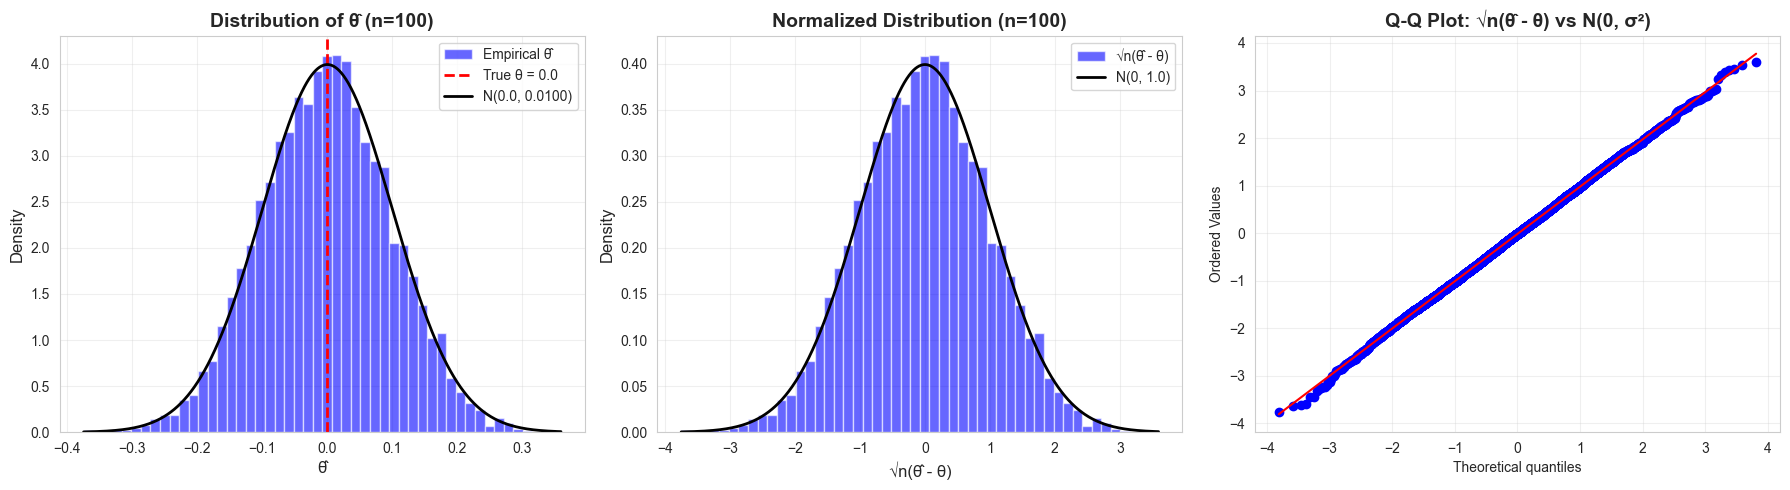

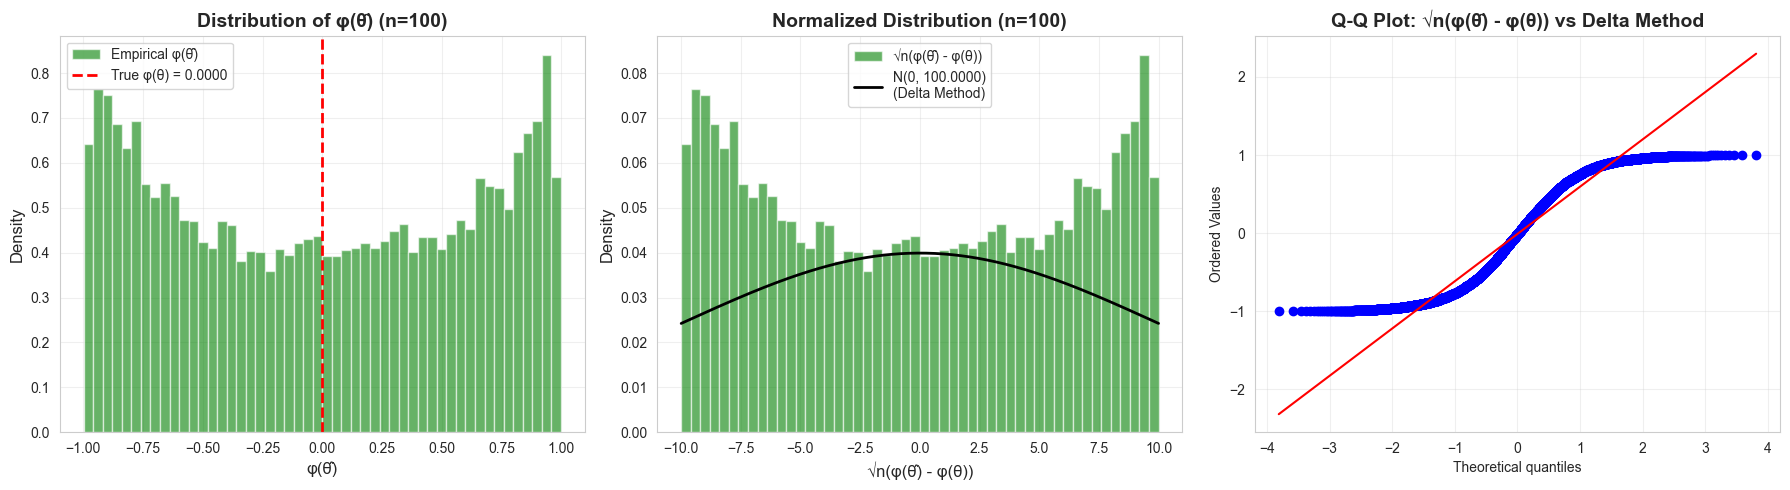

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: θ̂ vs θ
ax = axes[0]
ax.hist(theta_hats, bins=50, density=True, alpha=0.6, label='Empirical θ̂', color='blue')
ax.axvline(theta, color='red', linestyle='--', linewidth=2, label=f'True θ = {theta}')

# Theoretical distribution of θ̂
x_range = np.linspace(theta_hats.min(), theta_hats.max(), 1000)
theoretical_density = stats.norm.pdf(x_range, theta, np.sqrt(sigma_squared/n))
ax.plot(x_range, theoretical_density, 'k-', linewidth=2, label=f'N({theta}, {sigma_squared/n:.4f})')

ax.set_xlabel('θ̂', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Distribution of θ̂ (n={n})', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Normalized √n(θ̂ - θ) vs N(0, σ²)
ax = axes[1]
ax.hist(normalized_theta, bins=50, density=True, alpha=0.6, label='√n(θ̂ - θ)', color='blue')

# Theoretical N(0, σ²)
x_range = np.linspace(normalized_theta.min(), normalized_theta.max(), 1000)
theoretical_density = stats.norm.pdf(x_range, 0, np.sqrt(sigma_squared))
ax.plot(x_range, theoretical_density, 'k-', linewidth=2, label=f'N(0, {sigma_squared})')

ax.set_xlabel('√n(θ̂ - θ)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Normalized Distribution (n={n})', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Q-Q plot for θ̂
ax = axes[2]
stats.probplot(normalized_theta, dist="norm", plot=ax)
ax.set_title('Q-Q Plot: √n(θ̂ - θ) vs N(0, σ²)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ---- visualize phi ------

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: φ(θ̂) vs φ(θ)
ax = axes[0]
ax.hist(phi_theta_hats, bins=50, density=True, alpha=0.6, label='Empirical φ(θ̂)', color='green')
ax.axvline(phi_theta, color='red', linestyle='--', linewidth=2, label=f'True φ(θ) = {phi_theta:.4f}')

# Note: The theoretical distribution of φ(θ̂) is complicated without delta method
# We'll add the delta method approximation below

ax.set_xlabel('φ(θ̂)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Distribution of φ(θ̂) (n={n})', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Normalized √n(φ(θ̂) - φ(θ)) vs N(0, φ'(θ)²σ²)
ax = axes[1]
ax.hist(normalized_phi, bins=50, density=True, alpha=0.6, label='√n(φ(θ̂) - φ(θ))', color='green')

# Theoretical delta method approximation: N(0, φ'(θ)²σ²)
delta_method_variance = (phi_prime_theta**2) * sigma_squared
x_range = np.linspace(normalized_phi.min(), normalized_phi.max(), 1000)
if delta_method_variance > 0:
    theoretical_density = stats.norm.pdf(x_range, 0, np.sqrt(delta_method_variance))
    ax.plot(x_range, theoretical_density, 'k-', linewidth=2, 
            label=f'N(0, {delta_method_variance:.4f})\n(Delta Method)')

ax.set_xlabel('√n(φ(θ̂) - φ(θ))', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title(f'Normalized Distribution (n={n})', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 3: Q-Q plot for φ(θ̂)
ax = axes[2]
if delta_method_variance > 0:
    # Standardize by the delta method variance
    standardized_phi = normalized_phi / np.sqrt(delta_method_variance)
    stats.probplot(standardized_phi, dist="norm", plot=ax)
    ax.set_title('Q-Q Plot: √n(φ(θ̂) - φ(θ)) vs Delta Method', fontsize=14, fontweight='bold')
else:
    ax.text(0.5, 0.5, "φ'(θ) = 0\nDelta method fails!", 
            ha='center', va='center', fontsize=14, transform=ax.transAxes)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Explore Different Sample Sizes

See how the approximations improve as n increases.

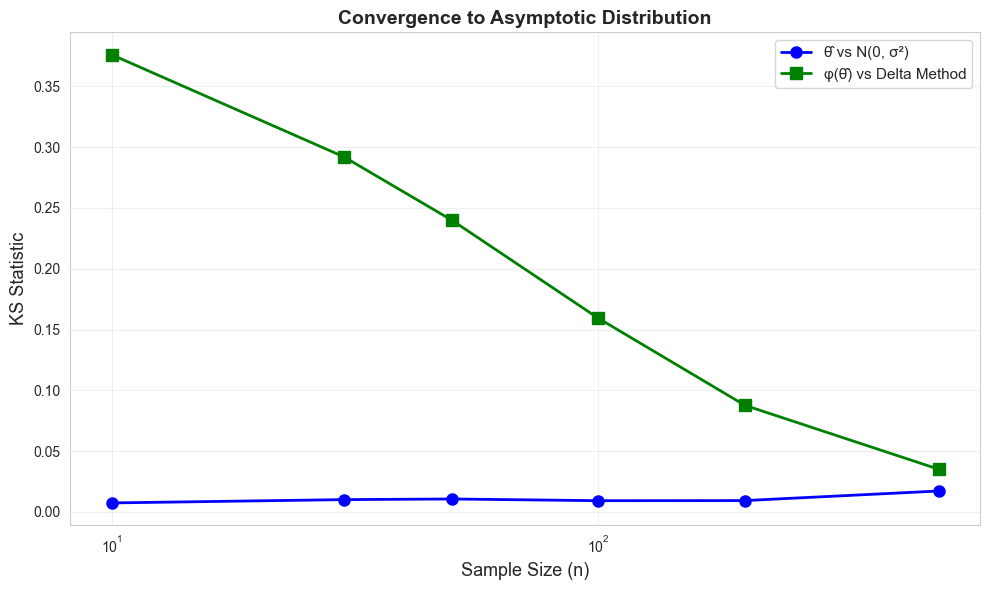

In [7]:
# Try different sample sizes
sample_sizes = [10, 30, 50, 100, 200, 500]
n_sims_quick = 5000  # Use fewer simulations for speed

# Store KS statistics for each n
ks_stats_theta = []
ks_stats_phi = []

for n_test in sample_sizes:
    theta_hats_test = np.zeros(n_sims_quick)
    phi_theta_hats_test = np.zeros(n_sims_quick)
    
    for i in range(n_sims_quick):
        X = sample_Xi(theta, n_test, sigma_squared)
        theta_hats_test[i] = np.mean(X)
        phi_theta_hats_test[i] = phi(theta_hats_test[i])
    
    # Normalize
    normalized_theta_test = np.sqrt(n_test) * (theta_hats_test - theta)
    normalized_phi_test = np.sqrt(n_test) * (phi_theta_hats_test - phi_theta)
    
    # Kolmogorov-Smirnov test for normality
    ks_theta = stats.kstest(normalized_theta_test, 
                            lambda x: stats.norm.cdf(x, 0, np.sqrt(sigma_squared)))
    ks_stats_theta.append(ks_theta.statistic)
    
    if delta_method_variance > 0:
        ks_phi = stats.kstest(normalized_phi_test,
                             lambda x: stats.norm.cdf(x, 0, np.sqrt(delta_method_variance)))
        ks_stats_phi.append(ks_phi.statistic)
    else:
        ks_stats_phi.append(np.nan)

# Plot KS statistics vs sample size
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(sample_sizes, ks_stats_theta, 'o-', linewidth=2, markersize=8, 
        label='θ̂ vs N(0, σ²)', color='blue')
ax.plot(sample_sizes, ks_stats_phi, 's-', linewidth=2, markersize=8,
        label='φ(θ̂) vs Delta Method', color='green')

ax.set_xlabel('Sample Size (n)', fontsize=13)
ax.set_ylabel('KS Statistic', fontsize=13)
ax.set_title('Convergence to Asymptotic Distribution', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xscale('log')

plt.tight_layout()
plt.show()